# Algoritmos de aprendizado profundo

## Projeto final da disciplina

#### Por: Cristiane Máximo de Freitas, Daniel de Moura e Almeida, Frederico Chaves Carvalho, Leonardo Alvarenga Lopes Santos

___


## Códigos referentes aos procedimentos metodológicos 

Neste documento, trazemos os códigos necessários para reproduzir os experimentos relatados no texto principal.


### Passo 1 - Importar bibliotecas utilizadas

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, plot_roc_curve
from scipy.sparse import load_npz
import datetime
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Dropout, ReLU
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from datetime import datetime
from keras import backend as K
from scipy.sparse import load_npz
import math
import os
import re
import nltk
from pmaw import PushshiftAPI #!pip install pmaw
api = PushshiftAPI()
nltk.download('stopwords')
nltk.download('punkt') #Tokenização

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Passo 2 - Recuperar postagens nos subredddits selecionados a fim de identificar usuários que comunicaram diagnóstico ou não diagnóstico de depressão.

In [ ]:
subreddits = [sr.split('\n')[0].lower() for sr in list(open('/content/drive/MyDrive/UFMG/DL/mh_subreddits.txt').readlines())]
diag_patterns = pd.unique([dp.split('\n')[0].lower() for dp in list(open('/content/drive/MyDrive/UFMG/DL/diagpatterns_positive.txt').readlines())])
neg_patterns = pd.unique([np.split('\n')[0].lower() for np in list(open('/content/drive/MyDrive/UFMG/DL/depression-syns.txt').readlines())])
syns = pd.unique([depr.split('\n')[0].lower() for depr in list(open('/content/drive/MyDrive/UFMG/DL/depression-syns.txt').readlines())])

# Se tiver dando warning, alterar frequência para dia
dates = pd.date_range('2021-01-01', '2022-01-01', freq='MS').strftime("%Y-%m-%d").tolist()  # 1 ano
positives = []
negatives = []
k = 0
dest_folder = 'SMHD_2021/'
for subreddit in subreddits:
    i = 0
    last_i = -1
    pos_dict = {'author': [], 'date': [], 'post_title': [], 'post_text': [], 'subreddit': []}
    neg_dict = {'author': [], 'date': [], 'post_title': [], 'post_text': [], 'subreddit': []}
    for j in range(len(dates)-1):
        before = int(pd.to_datetime(dates[j+1]).timestamp())
        after = int(pd.to_datetime(dates[j]).timestamp())
        try:
            posts = api.search_submissions(subreddit=subreddit, limit=None, before=before, after=after)
        except:
            continue
        for dc in posts.responses:
            try:
                t = dc['selftext']
            except:
                continue
            for dp in diag_patterns:
                if dp in str(t).lower():
                    for s in syns:
                        if s in str(t).lower():
                            if i != last_i:
                                positives.append(dc['author'])
                                pos_dict['author'].append(dc['author'])
                                pos_dict['post_title'].append(dc['title'])
                                pos_dict['post_text'].append(t)
                                pos_dict['date'].append(datetime.datetime.fromtimestamp(dc['created_utc']).date())
                                pos_dict['subreddit'].append(subreddit)
                                last_i = i
            last_i = -1
            for np in neg_patterns:
                if np in str(t).lower():
                    for s in syns:
                        if s in str(t).lower():
                            if i != last_i:
                                negatives.append(dc['author'])
                                neg_dict['author'].append(dc['author'])
                                neg_dict['post_title'].append(dc['title'])
                                neg_dict['post_text'].append(t)
                                neg_dict['date'].append(datetime.datetime.fromtimestamp(dc['created_utc']).date())
                                neg_dict['subreddit'].append(subreddit)
                                last_i = i
            i += 1
    pos_df = pd.DataFrame(pos_dict)
    pos_df = pos_df.set_index('author')
    pos_df.to_csv(dest_folder + subreddit + '_pos_' + str(k) + '.csv')
    neg_df = pd.DataFrame(neg_dict)
    neg_df = neg_df.set_index('author')
    neg_df.to_csv(dest_folder + subreddit + '_neg_' + str(k) + '.csv')
    k += 1
    del pos_df, pos_dict
    del neg_df, neg_dict

In [ ]:
diag_patterns

array(['i am diagnosed with', 'i got diagnos', 'i just got diagnos',
       'i have been diagnos', 'i was diagnos', 'i have a diagnos',
       'i have diagnos', "i've been diagnos",
       'i suffer from clinically diagnos', 'i suffer from diagnos',
       "i've been diagnosed with", 'my doctor diagnosed me',
       'she diagnosed me', 'he diagnosed me', 'they diagnosed me',
       'recently diagnosed me as', 'i was recently diagnos',
       'i have recently been diagnos', 'i have been recently diagnos',
       'until i was diagnosed this year', 'last year i was diagnos',
       'i have honestly diagnosed', 'they diagnosed me with',
       'as someone with a diagnos', 'im diagnos', "i'm diagnos",
       'i was _doctor diagnos', "i've been _doctor diagnos",
       'i have been _doctor diagnos', 'i was just diagnos',
       "i've been recently diagnos", "i've recently been diagnos",
       "i've just been diagnos", "i've only recently been diagnos",
       "i've only been diagnos", '_doc

### Unindo os arquivos com diagnóstico positivos e negatívos

In [ ]:
df_neg=pd.read_csv('/content/drive/MyDrive/UFMG/final_neg.csv')
df_neg['target']=0
df_pos=pd.read_csv('/content/drive/MyDrive/UFMG/final_pos.csv')
df_pos['target']=1
df=[df_neg,df_pos]
data = pd.concat(df)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12705 entries, 0 to 9030
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      12705 non-null  object
 1   date        12705 non-null  object
 2   post_title  12705 non-null  object
 3   post_text   12705 non-null  object
 4   subreddit   12705 non-null  object
 5   target      12705 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 694.8+ KB


### Passo 2.1 - Refinar os posts de maneira a evitar falsas detecções (FP / FN), limitando o contexto analisado após a identificação do padrão de diagnóstico.
Após identificarmos no texto cada expressão que indicassem o início de uma auto-declaração de diagnóstico, buscou-se um dos sinônimos de depressão (ex: depression, dysthymia, major depressive disorder, etc.) nos 100 caracteres seguintes. 
Já a identificação dos casos negativos foi realizada identificando-se as expressões que indicassem negativa de diagnóstico nos 50 caracteres anteriores ou seguintes. Autores que porventura tivessem postagens que se encaixassem em ambos os padrões foram removidos das análises.


In [ ]:
indices_p = []
indices_n = []
for j in range(len(data)):
    t = data.iloc[j]['post_text'].lower()
    i = 0
    last_i = -1
    for dp in diag_patterns:
        if dp in str(t).lower():
            posterior = str(t).lower().split(dp)[1][:100]
            for s in syns:
                if s in posterior:
                    if i != last_i:
                        indices_p.append(j)
                        last_i = i
    last_i = -1
    for negp in neg_patterns:
        if negp in str(t).lower():
            posterior = str(t).lower().split(negp)[1][:50]
            anterior = str(t).lower().split(negp)[0][50:]
            for s in syns:
                if s in posterior or s in anterior:
                    if i != last_i:
                        indices_n.append(j)
                        last_i = i
k = 0
for n in reversed(indices_n):
    if n in indices_p:
        k +=1
        indices_n.remove(n)
        indices_p.remove(n)  
        
new_pos = data.iloc[indices_p]
new_neg = data.iloc[indices_n]
new_pos['target'] = 1
new_neg['target'] = 0
data = pd.concat([new_pos, new_neg])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Passo 2.2 - Obter posts dos autores selecionados anteriormente

Efetuamos nova chamada da API para buscar os posts de cada usuário 6 meses posteriores e 6 meses anteriores à auto-declaração.

In [ ]:
os.makedirs('SMHD_authors', exist_ok=True)
os.makedirs('SMHD_authors/neg', exist_ok=True)
os.makedirs('SMHD_authors/pos', exist_ok=True)
api = PushshiftAPI()

cols = ['author', 'selftext', 'title', 'created_utc', 'subreddit']
failed_authors = []
#author_df = pd.read_csv('preprocessed_data.csv', index_col=0)
author_df = data.copy()
author_df.drop_duplicates(inplace=True)
author_df.loc[:, 'date'] = pd.to_datetime(author_df.loc[:, 'date'])
author_dict = {'neg': author_df.loc[author_df['target'] == 0].copy(),
               'pos': author_df.loc[author_df['target'] == 1].copy()}
for target, author_df in author_dict.items():
    # Filtrando fora o AutoModerator do Reddit
    author_df = author_df.loc[~author_df['author'].isin(['AutoModerator', '[deleted]'])]

    # Setando as datas do primeiro e último posts do autor daquela classe
    group_dates = author_df.groupby('author')['date']
    author_df.set_index('author', inplace=True)
    author_df.loc[:, 'first_date'] = group_dates.min().copy()
    author_df.loc[:, 'last_date'] = group_dates.max().copy()
    author_df = author_df.reset_index().copy()

    df = pd.DataFrame(columns=cols)
    for author_post in tqdm(author_df.iterrows()):
        full_author_df = pd.DataFrame(columns=cols)
        if os.path.isfile(f'SMHD_authors/{target}/{author_post[1].author}.csv'):
            if pd.read_csv(f'SMHD_authors/{target}/{author_post[1].author}.csv').shape[0] > 0:
                # print(f'Já li o autor {author_post[1].author}')
                continue
        try:
            out = api.search_submissions(author=author_post[1].author,
                                         limit=None,
                                         before=int((author_post[1].first_date + datetime.timedelta(days=180)).timestamp()),
                                         after=int((author_post[1].last_date - datetime.timedelta(days=180)).timestamp()))
        except:
            failed_authors.append(author_post[1].author)
            continue
        for post in out.responses:
            post_df = pd.Series(post)
            full_author_df = full_author_df.append(post_df.loc[cols], ignore_index=True)
        full_author_df.to_csv(f'SMHD_authors/{target}/{author_post[1].author}.csv', index=False)
    print(failed_authors)

data = full_author_df.copy()

### Passo 3 - Tratar os posts recuperados dos autores e efetuar préprocessamento dos dados

Excluímos todas as postagens nas quais os autores declaravam explicitamente ter sido diagnosticados, com vista a evitar contaminação do corpus. Agrupamos  os posts de 5 em 5, por autor e efetuamos o préprocessamento. Ao final, obtivemos um _corpus_ com 20.390 ocorrências, dos quais 14.385 referem-se a usuários diagnosticados e 6005 a usuários não-diagnosticados.

In [ ]:
df_neg=pd.read_csv('/content/drive/MyDrive/UFMG/DL/df_neg.csv')
df_pos=pd.read_csv('/content/drive/MyDrive/UFMG/DL/df_pos.csv')
df_neg.rename(columns={'selftext': 'post_text'}, inplace=True)
df_pos.rename(columns={'selftext': 'post_text'}, inplace=True)
df_neg.head()

,Unnamed: 0,author,post_text,title,created_utc,subreddit,diag_post,target,space_count
0,0,-pinkalicious-,i might be bi (15f) but idk i don't wanna say ...,what am i? [Discussion],1583047766,LGBTeens,False,0,98
1,1,-pinkalicious-,i don't want to self diagnose myself with depr...,possibly depressed,1583037452,depression,True,0,147
2,2,-rebel8852-,Idk what's wrong with me but I just can't have...,I can't talk to the guys I like,1592880397,Crushes,False,0,123
3,3,-rebel8852-,Kinda want to watch it for Ji Hyo but I've nev...,Is Lovely Horribly (Song Ji Hyo) worth watching?,1592625389,kdramarecommends,False,0,26
4,4,-rebel8852-,I'm probably one of the rare few people who do...,Does anyone else not get cravings for sweet sn...,1592556049,CasualConversation,False,0,88


In [ ]:
# Tamanho inicial da base (post de usuários auto declarados ou não como depressivos em um período de 2 anos)
print(df_neg.shape)
print(df_pos.shape)

(31273, 9)
(69438, 9)


In [ ]:
data = pd.concat([df_neg, df_pos])
print(data['post_text'].isnull().values.any())
print("nulos",data['post_text'].isnull().values.sum())

False
nulos 0


Excluindo autor "AutoModerator", posts com menos de 2 espaços e marcando o post utilizado para identificar o diagnóstico

In [ ]:
data.drop_duplicates(inplace=True)
df_base = data.loc[data['author'] != 'AutoModerator']

df_base_pos = df_base.loc[df_base['target'] == 1]
df_pos = pd.DataFrame()
pasta = 'SMHD_authors/pos/'
for aut_file in tqdm(os.listdir(pasta)):
    df_aut = pd.read_csv(pasta + aut_file)
    if aut_file[:-4] in set(df_base_pos.author):
        df_aut['diag_post'] = False
        df_aut['target'] = 1
        # Limpezas necessárias
        df_aut.dropna(subset=['selftext'], inplace=True)
        df_aut['space_count'] = df_aut['selftext'].str.count(' ')
        # Só mantemos quem tem pelo menos 2 espaços
        df_aut = df_aut.loc[df_aut['space_count'] > 1]
        # Marcando o post do diagnóstico
        filtro = df_aut['selftext'].isin(df_base_pos.loc[df_base_pos['author'] == aut_file[:-4], 'post_text'])
        df_aut.loc[filtro, 'diag_post'] = True
        df_pos = pd.concat([df_pos, df_aut], ignore_index=True)
df_pos.to_csv('df_pos.csv')


df_base_neg = df_base.loc[df_base['target'] == 0]
df_neg = pd.DataFrame()
pasta = 'SMHD_authors/neg/'
for aut_file in tqdm(os.listdir(pasta)):
    df_aut = pd.read_csv(pasta + aut_file)
    if aut_file[:-4] in set(df_base_neg.author):
        df_aut['diag_post'] = False
        df_aut['target'] = 0
        # Limpezas necessárias
        df_aut.dropna(subset=['selftext'], inplace=True)
        df_aut['space_count'] = df_aut['selftext'].str.count(' ')
        # Só mantemos quem tem pelo menos 2 espaços
        df_aut = df_aut.loc[df_aut['space_count'] > 1]
        # Marcando o post do diagnóstico
        filtro = df_aut['selftext'].isin(df_base_neg.loc[df_base_neg['author'] == aut_file[:-4], 'post_text'])
        df_aut.loc[filtro, 'diag_post'] = True
        df_neg = pd.concat([df_neg, df_aut], ignore_index=True)
df_neg.to_csv('df_neg.csv')

data = pd.concat([df_neg, df_pos])

Excluindo autores que cairam em ambas as classificações

In [ ]:
print(f"Shape pré remoção dos ambíguos: {data.shape}")
negat = pd.unique(df_neg['author'])
posit = pd.unique(df_pos['author']) 
ambiguous = []
for n in negat:
    if n in posit:
        ambiguous.append(n)

data = data.loc[~(data['author'].isin(ambiguous))]
print(f"Shape pós remoção dos ambíguos: {data.shape}")

Shape pré remoção dos ambíguos: (100711, 9)
Shape pós remoção dos ambíguos: (94733, 9)


### Passo 3.1 - Preprocessamento dos textos

Remoção de pontuação, números, stop-words, conversão para minúsculo e trocar todos os sinônimos de depressão pelo termo depressão. 


In [ ]:
stop_words= stopwords.words("english")

def preprocessing_txt(text):
    clean_text=[]
    tokens= []
    for words in tqdm(text):
        words= re.sub(r"won't" ,"will not" , words)
        words= re.sub(r"can\'t", "can not",words )
        words = re.sub(r"n\'t", " not", words)
        words = re.sub(r"\'re", " are", words)
        words = re.sub(r"\'s", " is", words)
        words = re.sub(r"\'d", " would", words)
        words = re.sub(r"\'ll", " will", words)
        words = re.sub(r"\'t", " not", words)
        words = re.sub(r"\'ve", " have", words)
        words = re.sub(r"\'m", " am", words)
        words= re.sub(r"\d+","",words)
        words = words.replace("im", "I am")
        words= words.replace("\\r", " ")
        words= words.replace("\\n", " ")
        words= words.replace('\\"', ' ')
        words= re.sub("[^A-Za-z0-9]+", " ", words)
        words = ' '.join(i for i in words.split() if i.lower() not in stop_words)
        clean_text.append(words.lower().strip())
        
    return clean_text
                             
data["cleaned_text"]= preprocessing_txt(data["post_text"])

for synonym in syns:
    data['cleaned_text'] = data['cleaned_text'].str.replace(synonym, 'depression')  #trocando por sinônimos


100%|██████████| 100711/100711 [00:54<00:00, 1843.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: The default value of regex will change from True to False in a future version.


Tokenização, criação de coluna de data do diagnóstico

In [ ]:
def identify_tokens(row):
    texts = row['cleaned_text']
    tokens = nltk.word_tokenize(texts)
    token_words = [w for w in tokens]
    return token_words

data['tokenized_words'] = data.apply(identify_tokens, axis=1)

#Criando coluna Data do Diagnóstico
data['post_date'] = data.loc[:, 'created_utc'].apply(datetime.fromtimestamp)
diag = data.loc[data['diag_post']].groupby('author')['post_date'].min().reset_index()
diag.rename(columns={'post_date': 'diag_date'}, inplace=True)
data = data.merge(diag, on='author', how='left')

Média de posts por autor: 15.656709265175719


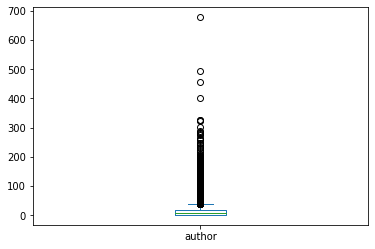

In [ ]:
# Visualizando a média de posts por autor
author = data.groupby('author').filter(lambda x: len(x) <1000)
pd.Series(author.loc[:, 'author'].value_counts()).plot.box()
print(f'Média de posts por autor: {author.loc[:, "author"].value_counts().mean()}')

In [ ]:
# Quantidade de posts não depressivos por comunidade
print(data.loc[data['target'] == 0, 'subreddit'].value_counts())

ADHD               1543
EatingDisorders    1349
depression         1253
mentalhealth        893
teenagers           657
                   ... 
communism             1
roommates             1
f1visa                1
TopsAndBottoms        1
u__texassin_          1
Name: subreddit, Length: 4267, dtype: int64


In [ ]:
# Quantidade de posts depressivos por comunidade
print(data.loc[data['target'] == 1, 'subreddit'].value_counts())

depression         3998
ADHD               2394
mentalhealth       2285
SuicideWatch       1528
EatingDisorders    1349
                   ... 
auslan                1
eurobeat              1
OneyPlays             1
Korg                  1
AdviceForTeens        1
Name: subreddit, Length: 7389, dtype: int64


Aplicação de stemmming para reduzir o vocabulário e tornar os textos mais comparáveis. 

In [ ]:
# Stemming
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

data['stemmed_tokens'] = data['tokenized_words'].apply(stem_tokens)

Média de palavras por post: 85.9194129737566


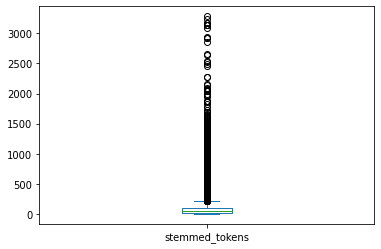

In [ ]:
data['stemmed_tokens'].apply(len).plot.box()
print(f'Média de palavras por post: {data["stemmed_tokens"].apply(len).mean()}')

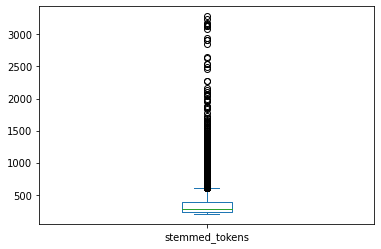

In [ ]:
data.loc[data['stemmed_tokens'].apply(len) > 200, 'stemmed_tokens'].apply(len).plot.box()

Agrupando os posts em tuplas em grupos de 5

In [ ]:
# Agrupando os posts em tuplas
def group_posts(post_series):
    i = 0
    posts = []
    posts_count = []
    while i < len(post_series):
        posts_batch = []
        for j in range(min(i + 5, len(post_series) - i)):
            posts_batch = posts_batch + post_series.iloc[i + j]
        posts_count.append(j + 1)
        posts.append(posts_batch)
        i += 5
    return pd.DataFrame({'final_tokens': posts,
                         'posts_count': posts_count})

data = data.sort_values(by=['stemmed_tokens'], key=lambda x: x.apply(len)) # ordenando pelo tamanho dos posts
final_df = data.groupby('author')['stemmed_tokens'].apply(group_posts).reset_index('author')
final_df.head()

,author,final_tokens,posts_count
0,-Izanami-,"[hello, fairli, activ, player, ive, die, play,...",5
1,-Izanami-,"[found, cool, race, want, tri, dnd, wiki, seem...",1
0,-StarvingArtist-,"[got, hire, spot, local, club, start, next, we...",5
1,-StarvingArtist-,"[hey, guy, becam, cam, girl, free, cam, recent...",5
0,-_Jacket-_-,"[start, pri, amal, diet, day, ago, eat, book, ...",4


In [ ]:
# Filtrando tuplas com posts com menos de 150 palavras
print(f'Linhas antes de filtrar {final_df.shape[0]}')
min_words = 150
final_df = final_df.loc[(final_df['posts_count'] == 5) | (final_df['final_tokens'].apply(len) >= min_words)]
print(f'Linhas depois de filtrar {final_df.shape[0]}')

# Destokenizando para usar no TFIDF e nas redes profundas
final_df['final_text'] = final_df['final_tokens'].apply(lambda x: ' '.join(x))
final_df = final_df.loc[final_df['final_text'] != '']

Linhas antes de filtrar 23095
Linhas depois de filtrar 21586


### Passo 3.2 - Separar dados em treino e teste

In [ ]:
# Separando em treino e teste
authors = final_df['author'].unique()
np.random.seed(42)
np.random.shuffle(authors)
perc_treino = 0.7
train_authors = authors[:math.floor(perc_treino*len(authors))]
test_authors = authors[math.floor(perc_treino*len(authors)):]
train_df = final_df.loc[final_df['author'].isin(train_authors)].merge(data.loc[:, ['author', 'target']].drop_duplicates(), how='inner', on='author')
test_df = final_df.loc[final_df['author'].isin(test_authors)].merge(data.loc[:, ['author', 'target']].drop_duplicates(), how='inner', on='author')
X_train = train_df.loc[:, 'final_text']
X_train_tokens = train_df.loc[:, 'final_tokens']
y_train = train_df.loc[:, 'target']
X_test = test_df.loc[:, 'final_text']
X_test_tokens = test_df.loc[:, 'final_tokens']
y_test = test_df.loc[:, 'target']
print(train_df.shape[0])
print(test_df.shape[0])

16016
6764


In [ ]:
# Exportando arquivos
final_df.to_csv('preprocessed.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_train_tokens.to_csv('X_train_tokens.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
X_test_tokens.to_csv('X_test_tokens.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

## MODELO 1 -  LSTM COM ENTRADA PROVENIENTE DO TOKENIZADOR POR ÍNDICES

Formatar os textos como tensores de entrada para a LSTM usando o Tokenizador do keras

In [ ]:
# Tokenizando as palavras 
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(X_train['final_text'].values)
X_train = tokenizer.texts_to_sequences(X_train['final_text'].values)
X_test = tokenizer.texts_to_sequences(X_test['final_text'].values)

# Geração de pading para que todos os posts tenham o mesmo tamanho
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

# Reformatar a entrada para ser (500, 1) e não (500,), pois a LSTM exige que a entrada seja bidimensional
new_X_train = []
for i in range(len(X_train)):
    new_X_train.append(X_train[i][-500:].reshape(500, 1)) 
new_X_train = np.array(new_X_train)

new_X_test = []
for i in range(len(X_test)):
    new_X_test.append(X_test[i][-500:].reshape(500, 1))
new_X_test = np.array(new_X_test)

In [ ]:
# Definição de métricas auxiliares para o treinamento

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Construindo a arquitetura da rede LSTM

In [ ]:
# Definição do modelo LSTM
model = Sequential()
model.add(Input(shape=(new_X_train.shape[1:])))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())

### Treinamento e avaliação do modelo 

In [ ]:
# Treino da rede e print das métricas
batch_size = 32
model.fit(new_X_train, y_train, epochs = 20, batch_size=batch_size, verbose = 'auto')

print('Avaliação final do modelo no treino')
print(model.evaluate(new_X_test, y_test))

print('Avaliação final do modelo no teste')
print(model.evaluate(new_X_train, y_train))

## MODELO 2 -  MLP E MODELOS CLÁSSICOS UTILIZANDO TF-IDF

### Aplicar o TF-IDF aos documentos/postagens

In [ ]:
# Gerando TF-IDF e aplicando aos documentos
tf_idf_vec = TfidfVectorizer(min_df=200, max_df=0.9)

tf_idf_train_data = tf_idf_vec.fit_transform(X_train['final_text'])
tf_idf_test_data = tf_idf_vec.transform(X_test['final_text'])
print(tf_idf_train_data.shape)

save_npz('tfidf_train.npz', tf_idf_train_data)
save_npz('tfidf_test.npz', tf_idf_test_data)

In [ ]:
np.savetxt("tfidf_train.csv", tf_idf_train_data.toarray(), delimiter=",")
np.savetxt("tfidf_test.csv", tf_idf_test_data.toarray(), delimiter=",")
tfidf_train_df = pd.DataFrame(tf_idf_train_data.toarray(), columns=tf_idf_vec.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tf_idf_test_data.toarray(), columns=tf_idf_vec.get_feature_names_out())
tfidf_train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/tfidf_train.csv', index=False)
tfidf_test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/tfidf_test.csv', index=False)

### Treinar e avaliar os modelos Naive Bayes, Decision Tree, SVM, KNN, Random Forest e MLP utilizando TF-IDF como entrada

In [ ]:
# Importação dos dados
X_treino = load_npz('../Dataset/tfidf_train.npz').toarray()
y_treino = pd.read_csv('../Dataset/y_train.csv')['target']
X_teste = load_npz('../Dataset/tfidf_test.npz').toarray()
y_teste = pd.read_csv('../Dataset/y_test.csv')['target']


# Função para treino, predict e cálculo da métricas
def testa_classificador(classificador, x_treino, y_treino, x_teste, y_teste, ax1, ax2,fig, nome, show_plot):
    # Inicialização das listas para armazenar os resultados
    acuracia = []
    precisao = []
    recall = []
    area_curva_roc = []
    curvas_roc = []
    i = 0

    # Fit do classificador ao conjunto de treino da iteração
    classificador.fit(x_treino, y_treino)

    # Aplicação do classificador para prever os valores do subconjunto de teste
    predicao = classificador.predict(x_teste)

    # Cálculo das métricas selecionadas
    ac = accuracy_score(y_teste, predicao)
    acuracia.append(ac)
    pre = precision_score(y_teste, predicao, average='macro')
    precisao.append(pre)
    rec = recall_score(y_teste, predicao, average= 'macro')
    recall.append(rec)

    # Plotagem da curva ROC e extrai o valor da área sob a curva
    name = nome + " K" + str(i)
    curva = plot_roc_curve(classificador, x_teste, y_teste, ax = ax1, name = name)
    area_curva_roc.append(curva.roc_auc)
    curvas_roc.append(curva)

    # Cálculo e plotagem da curva ROC média
    x_medio = np.linspace(0,1,100)
    y_medio = np.zeros_like(x_medio)
    auc_medio = 0
    for ROC in curvas_roc:
        y_curva_interp = np.interp(x_medio, ROC.line_.get_xdata(), ROC.line_.get_ydata())
        y_medio += y_curva_interp
        auc_medio += ROC.roc_auc

    auc_medio = auc_medio / 5
    y_medio = y_medio / 5
    ax2.plot(x_medio,y_medio, color='k')
    legenda = nome + " médio (AUC = " + str(round(auc_medio, 2)) + ")"
    ax2.legend([legenda], loc = 'lower right')
    ax1.set_title('Curvas ROC para cada um dos K-Folds')
    ax2.set_title('Curva ROC média')
    ax2.set_xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig('../Resultados/Testa_classificador_'+nome+'.png')

    return (acuracia, precisao, recall, area_curva_roc, [x_medio, y_medio], auc_medio)

# Salva métricas em um dicionário
def sumarizar(resultados):
    # Inicializa dicionário com classes nomeadas
    sumario = {'acurácia_média': [], 'precisão_média': [], 'revocação_média': [], 'área média sob a curva ROC': []}

    # Preenche o dicionário com os valores correspondentes
    for resultado in resultados:
        acuracia_media = sum(resultado[0]) / len(resultado[0])
        sumario['acurácia_média'].append(acuracia_media)
        acuracia_media = sum(resultado[1]) / len(resultado[1])
        sumario['precisão_média'].append(acuracia_media)
        acuracia_media = sum(resultado[2]) / len(resultado[2])
        sumario['revocação_média'].append(acuracia_media)
        sumario['área média sob a curva ROC'].append(resultado[5])
    return sumario

In [ ]:
# Modelo Naive Bayes
classificador_NB = GaussianNB()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
resultado_NB = testa_classificador(classificador_NB, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "Naive Bayes", show_plot = True)
joblib.dump(resultado_NB, 'outputs/Res_NB.pkl')
joblib.dump(classificador_NB, 'outputs/NaiveBayes.pkl')
sumario = sumarizar([resultado_NB])
resultado_df =  pd.DataFrame(sumario)
resultado_df.to_csv('../Resultados/')

In [ ]:
# Decision Tree variando alturas: 50,100, None
alturas = [50,100, None]
resultados = []
for altura in alturas:
    classificador_DT = tree.DecisionTreeClassifier(criterion='entropy', max_depth = altura)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    resultados.append(testa_classificador(classificador_DT, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "Árvore de decisão", show_plot = False))
    joblib.dump(classificador_DT, 'outputs/Arvore_' + str(altura) + '.pkl')

joblib.dump(resultados, 'outputs/Res_Arvore.pkl')
sumario = sumarizar(resultados)
sumario['altura máxima'] = ['50', '100']
resultados_df = pd.DataFrame(sumario)
resultados_df = resultados_df.set_index(["altura máxima"])
resultados_df.to_csv('outputs/Arvores.csv')

In [ ]:
# SVM variando kernel: 'linear', 'polinomial', 'sigmoide', 'rbf'
classificador_SVM_lin = svm.SVC(kernel= "linear")
classificador_SVM_poly = svm.SVC(kernel= "poly")
classificador_SVM_sig = svm.SVC(kernel= "sigmoid")
classificador_SVM_rbf = svm.SVC(kernel='rbf')
classificadores_SVM = [classificador_SVM_lin, classificador_SVM_poly, classificador_SVM_sig, classificador_SVM_rbf]

resultado_SVM = []
i = 0
tipos = ['linear', 'polinomial', 'sigmoide', 'rbf']
for classificador in classificadores_SVM:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    resultado_SVM.append(testa_classificador(classificador, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "SVM", show_plot = False))
    joblib.dump(classificador_DT, 'outputs/SVM_' + str(tipos[i]) + '.pkl')
    i += 1
    
joblib.dump(resultado_SVM, 'outputs/Res_SVM.pkl')
sumario = sumarizar(resultado_SVM)
sumario['kernel'] = tipos
resultados_df = pd.DataFrame(sumario)
resultados_df = resultados_df.set_index(["kernel"])
resultados_df.to_csv('outputs/SVM_results.csv')

In [ ]:
# K-Nearest Neighbours variando do K vizinhos: 5, 25, 50, 100
valores_k = [5, 25, 50, 100]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
resultados_knn = []
for valor in valores_k:
    classificador_KNN = KNeighborsClassifier(n_neighbors = valor)
    resultados_knn.append(testa_classificador(classificador_KNN, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "K-Nearest Neighbors", show_plot = False))
    joblib.dump(classificador_KNN, '../Resultados/KNN_' + str(valor) + '.pkl')
    joblib.dump(resultados_knn, '../Resultados/Res_KNN' + str(valor) + '.pkl')
sumario = sumarizar(resultados_knn)
sumario['K'] = valores_k
resultados_df = pd.DataFrame(sumario)
resultados_df = resultados_df.set_index(["K"])
resultados_df.to_csv('../Resultados/KNN.csv')

In [ ]:
# Random Forest variando número de árvores: 50, 100, 200
numero_arvores = [50, 100, 200]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
resultados_RF = []

for numero in numero_arvores:
    classificador_RF = RandomForestClassifier(n_estimators = numero, criterion = "entropy")
    resultados_RF.append(testa_classificador(classificador_RF, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "Random Forest", show_plot = False))
    joblib.dump(classificador_DT, 'outputs/RF_' + str(numero) + '.pkl')

joblib.dump(resultados_RF, 'outputs/Res_RF.pkl')
sumario = sumarizar(resultados_RF)
sumario['número de árvores'] = numero_arvores
resultados_df = pd.DataFrame(sumario)
resultados_df = resultados_df.set_index(['número de árvores'])
resultados_df.to_csv('outputs/Random_forest_results.csv')

In [ ]:
# MLP variando camada oculta: 2048, 512, 128, 32, 8
resultado_MLP = []
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
classificador_MLP = MLPClassifier(hidden_layer_sizes=(2048, 512, 128, 32, 8))
resultado_MLP.append(testa_classificador(classificador_MLP, X_treino, y_treino, X_teste, y_teste, ax1, ax2, fig, "Multi_Layer_Perceptron", show_plot = True))
joblib.dump(resultado_MLP, 'outputs/Res_MLP.pkl')
sumario = sumarizar(resultado_MLP)
resultado_MLP_final = pd.DataFrame(sumario)
resultado_MLP_final.to_csv('outputs/MLP.csv')
joblib.dump(classificador_DT, 'outputs/MLP.pkl')
